v1.0 - 19NOV2023 - возращено разбиение на квадратные подобласти без добавления нулевых/наиболее часто встречающихся значений

In [492]:
import cv2
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
import os
import time

In [454]:
def autozoning(path1, path2, dil_ker, dil_iter, iros_ker):

  #read images, convert from rgb to grayscale, median bluring
    blur1=cv2.medianBlur(cv2.cvtColor(cv2.imread(path1), cv2.COLOR_BGR2GRAY),1)
    blur2=cv2.medianBlur(cv2.cvtColor(cv2.imread(path2), cv2.COLOR_BGR2GRAY),1)

  #set dilotation and irosion kernel
    kernel_dil  = np.ones(dil_ker,np.uint8)
    kernel_iros = np.ones(iros_ker,np.uint8)

  #using dilatation and closing
    closing = cv2.morphologyEx(cv2.dilate(cv2.absdiff(blur1,blur2),kernel_dil,iterations = dil_iter), cv2.MORPH_CLOSE, kernel_dil)

  # Threshold.
  # Set values equal to or above 220 to 0.
  # Set values below 220 to 255.
    th, im_th = cv2.threshold(closing, np.median(closing)+3, 255, cv2.THRESH_BINARY_INV);

  # Copy the thresholded image.
    im_floodfill = im_th.copy()

  # Mask used to flood filling.
  # Notice the size needs to be 2 pixels than the image.

    h, w = im_th.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)


  # Floodfill from point (0, 0)
    cv2.floodFill(im_floodfill, mask, (5,5), 255);

  # Invert floodfilled image
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)

  #add borders to background
    for i in range(im_floodfill.shape[0]):
        im_floodfill[0][i]=255
        im_floodfill[int(im_floodfill.shape[0]-1)][i]=255
        im_floodfill[i][0]=255
        im_floodfill[i][int(im_floodfill.shape[0]-1)]=255

  #find conturs
    contours, hierarchy = cv2.findContours(im_floodfill, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  #find corners
    corners=[]
    for j in range(1,len(contours)):
        x_min=blur1.shape[0]
        x_max=0
        y_min=blur1.shape[1]
        y_max=0
        for i in range(contours[j].shape[0]):
            if contours[j][i][0][0]>y_max:
                y_max=contours[j][i][0][0]
            if contours[j][i][0][0]<y_min:
                y_min=contours[j][i][0][0]
            if contours[j][i][0][1]>x_max:
                x_max=contours[j][i][0][1]
            if contours[j][i][0][1]<x_min:
                x_min=contours[j][i][0][1]
        corners.append([x_min,x_max,y_min,y_max])

    def convert_to_grayscale(path):
        image = np.float32(cv2.imread(path))
        sz = image.shape
        values=np.zeros((image.shape[0],image.shape[1]))
        if (len(sz) == 3):
            for i in range(image.shape[0]):
                for j in range(image.shape[1]):
                    values[i][j] = (image[i][j][0]  + image[i][j][1]  + image[i][j][2])/3
        else:
            values = image;
        values = values/np.max(values)

        return values
    
    first=convert_to_grayscale(path1)
    second=convert_to_grayscale(path2)
    
    frame1=[]
    frame2=[]
    for frame_num in range(len(corners)):
        vars()['frame_1%d'%frame_num]=first[corners[frame_num][0]:corners[frame_num][1],corners[frame_num][2]:corners[frame_num][3]]
        vars()['frame_2%d'%frame_num]=second[corners[frame_num][0]:corners[frame_num][1],corners[frame_num][2]:corners[frame_num][3]]
        if np.sum(vars()['frame_1%d'%frame_num]-vars()['frame_2%d'%frame_num])!=0:
            frame1.append(vars()['frame_1%d'%frame_num])
            frame2.append(vars()['frame_2%d'%frame_num])
    
    return frame1, frame2

In [455]:
frame1, frame2 = autozoning(path1='/Users/danil/Documents/Python projects/Autozoning/sea1.png',path2=r'/Users/danil/Documents/Python projects/Autozoning/sea2.png',dil_ker=(5,5), dil_iter=15, iros_ker=(7,7))

In [459]:
def optical_flow(first, second, c0, A0, delta_t, alpha_c, alpha_a, alpha_t, step_num):

    def calculate_moments(values):
        return np.array([values.shape[1]//2,values.shape[0]//2])

    center=calculate_moments(first)

  #интегрирование системы (14)
    def dx_dt(A,c,x0,time):
        def F(x,t):
            dx1dt=A[0][0]*x[0]+A[0][1]*x[1]+c[0]
            dx2dt=A[1][0]*x[0]+A[1][1]*x[1]+c[1]
            return [dx1dt,dx2dt]
        solution = odeint(F,x0,time)
        return solution

  #закон смещения каждого пикселя
    def xT(A,c,time):
        time_direct=np.linspace(0, time)
        x1T=np.array([[0 for col in range(first.shape[1])] for row in range(first.shape[0])])
        x2T=np.array([[0 for col in range(first.shape[1])] for row in range(first.shape[0])])

        for i in range(first.shape[0]):
            for j in range(first.shape[1]):
                x0=[j,i]
                x0=x0-center
                solution=dx_dt(A,c,x0,time_direct)
                solution=solution+center
                x1T[i][j]=int(round(solution[int(time_direct.shape[0]-1)][0]))
                x2T[i][j]=int(round(solution[int(time_direct.shape[0]-1)][1]))

        return x1T, x2T

    def rho_recalculated(x1,x2):
        rho_recalc=np.array([[0.0 for col in range(first.shape[1])] for row in range(first.shape[0])])
        for i in range(second.shape[0]):
            for j in range(second.shape[1]):
                if(x2[i][j]<=first.shape[0]-1 and x2[i][j]>=0 and x1[i][j]<=first.shape[1]-1 and x1[i][j]>=0):
                    rho_recalc[x2[i][j]][x1[i][j]]=first[i][j]

        return rho_recalc

  #вычисление частной производной partial_rho/partial_x
    def drho_dx(rho):
        drho_dx1=np.zeros((np.shape(rho)[0], np.shape(rho)[1]))
        drho_dx2=np.zeros((np.shape(rho)[0], np.shape(rho)[1]))
        for i in range(1,np.shape(rho)[0]-1):
            for j in range(1,np.shape(rho)[1]-1):
                drho_dx1[i][j]=-rho[i-1][j-1]-2*rho[i][j-1]-rho[i+1][j-1]+rho[i-1][j+1]+2*rho[i][j+1]+rho[i+1][j+1]
                drho_dx2[i][j]=-rho[i-1][j-1]-2*rho[i-1][j]-rho[i-1][j+1]+rho[i+1][j-1]+2*rho[i+1][j]+rho[i+1][j+1]
        return [drho_dx1, drho_dx2]

  # p(T,x(T))-p̂(x(T))
    def difference(x1,x2):
        diff=np.array([[0.0 for col in range(first.shape[1])] for row in range(first.shape[0])])
        diff=rho_recalculated(x1,x2)-second
        return diff

  #вычисление ψ*
    drho_hat_dx=drho_dx(second)
    def psi_star(x1,x2):
        psiT_1=np.array([[0.0 for col in range(first.shape[1])] for row in range(first.shape[0])])
        psiT_2=np.array([[0.0 for col in range(first.shape[1])] for row in range(first.shape[0])])
        psiT_1=2*difference(x1,x2)*drho_hat_dx[0]
        psiT_2=2*difference(x1,x2)*drho_hat_dx[1]
        return psiT_1, psiT_2

  #интегрирование системы (18) в опратном порядке - поэтому выносим минус
    def dPsi_dt(A,Psi0,time):
        def F(Psi,t):
            dPsi1dt=Psi[0]*A[0][0]+Psi[1]*A[0][1]
            dPsi2dt=Psi[0]*A[1][0]+Psi[1]*A[1][1]
            return [dPsi1dt,dPsi2dt]
        solution = odeint(F,Psi0,time)
        return solution

  #ψ0 для каждого пикселя
    def Psi0(A, psiT_1, psiT_2, time):
        time_reverse = np.linspace(time, 0)
        Psi1_t0=np.array([[0.0 for col in range(first.shape[1])] for row in range(first.shape[0])])
        Psi2_t0=np.array([[0.0 for col in range(first.shape[1])] for row in range(first.shape[0])])

        for i in range(first.shape[0]):
            for j in range(first.shape[1]):
                PsiT=[psiT_1[i][j],psiT_2[i][j]]
                solution_1=dPsi_dt(A,PsiT,time_reverse)
                Psi1_t0[i][j]=solution_1[49][0]
                Psi2_t0[i][j]=solution_1[49][1]

        return Psi1_t0, Psi2_t0

  #Обратное интегрирование системы (1) для расчета градиента
    def xT_back(A,c,time):

        def dx_dt_back(A,c,x0,time):
            def F(x,t):
                dx1dt=-(A[0][0]*x[0]+A[0][1]*x[1]+c[0])
                dx2dt=-(A[1][0]*x[0]+A[1][1]*x[1]+c[1])
                return [dx1dt,dx2dt]
            solution = odeint(F,x0,time)
            return solution

        def xT(A,c,time):
            time_reverse=np.linspace(time, 0)
            x01_back=np.array([[0 for col in range(first.shape[1])] for row in range(first.shape[0])])
            x02_back=np.array([[0 for col in range(first.shape[1])] for row in range(first.shape[0])])

            for i in range(first.shape[0]):
                for j in range(first.shape[1]):
                    x__T=[j,i]
                    x__T=x__T-center
                    solution=dx_dt_back(A,c,x__T,time_reverse)
                    solution=solution+center
                    x01_back[i][j]=int(round(solution[int(time_reverse.shape[0]-1)][0]))
                    x02_back[i][j]=int(round(solution[int(time_reverse.shape[0]-1)][1]))

            return x01_back, x02_back

        return xT(A,c,time)[0], xT(A,c,time)[1]

    X1=np.array([[0]*first.shape[1] for i in range(first.shape[0])])
    X2=np.array([[0]*first.shape[1] for i in range(first.shape[0])])

    for i in range(first.shape[0]):
        for j in range(first.shape[1]):
            X1[i][j]=j-center[1]
            X2[i][j]=i-center[0]


    def dJ_dC(psiT_1,psiT_2,Psi1_t0,Psi2_t0,X1,X2,time,A,c):
        x0_1=[[0 for col in range(first.shape[1])] for row in range(first.shape[0])]
        x0_2=[[0 for col in range(first.shape[1])] for row in range(first.shape[0])]

        dJ_dc1=0.0
        dJ_dc2=0.0

        x0=xT_back(A,c,time)

        for i in range(first.shape[0]):
            for j in range(first.shape[1]):
                if(x0[1][i][j]<=first.shape[0]-1 and x0[1][i][j]>0 and x0[0][i][j]<=first.shape[1]-1 and x0[1][i][j]>0):
                    x0_1[i][j]=x0[0][i][j]-center[0]
                    x0_2[i][j]=x0[1][i][j]-center[1]

        Psi1=psiT_1+Psi1_t0
        Psi2=psiT_2+Psi2_t0
        dJ_dc1=-np.sum(Psi1)*time/2
        dJ_dc2=-np.sum(Psi2)*time/2

        return [dJ_dc1, dJ_dc2]

    def dJ_dA(psiT_1,psiT_2,Psi1_t0,Psi2_t0,X1,X2,time,A,c):
        x0_1=[[0 for col in range(first.shape[1])] for row in range(first.shape[0])]
        x0_2=[[0 for col in range(first.shape[1])] for row in range(first.shape[0])]
        dJ_dA11=0.0
        dJ_dA12=0.0
        dJ_dA21=0.0
        dJ_dA22=0.0

        x0=xT_back(A,c,time)

        for i in range(first.shape[0]):
            for j in range(first.shape[1]):
                if(x0[1][i][j]<=first.shape[0]-1 and x0[1][i][j]>0 and x0[0][i][j]<=first.shape[1]-1 and x0[1][i][j]>0):
                    x0_1[i][j]=x0[0][i][j]-center[0]
                    x0_2[i][j]=x0[1][i][j]-center[1]

        Psi1_x1=psiT_1*X1+Psi1_t0*x0_1
        Psi1_x2=psiT_1*X2+Psi1_t0*x0_2
        Psi2_x1=psiT_2*X1+Psi2_t0*x0_1
        Psi2_x2=psiT_2*X2+Psi2_t0*x0_2

        dJ_dA12=dJ_dA12-np.sum(Psi1_x2)*time/2
        dJ_dA21=dJ_dA21-np.sum(Psi2_x1)*time/2
        dJ_dA11=dJ_dA11-np.sum((Psi1_x1)-(Psi2_x2))*time/2
        dJ_dA22=-dJ_dA11


        return [dJ_dA11, dJ_dA12, dJ_dA21, dJ_dA22]

    def dJ_dT(psiT_1,psiT_2,Psi1_t0,Psi2_t0,X1,X2,time,A,c):
        x0_1=[[0 for col in range(first.shape[1])] for row in range(first.shape[0])]
        x0_2=[[0 for col in range(first.shape[1])] for row in range(first.shape[0])]

        dJ_dT=0.0

        x0=xT_back(A,c,time)

        for i in range(first.shape[0]):
            for j in range(first.shape[1]):
                if(x0[1][i][j]<=first.shape[0]-1 and x0[1][i][j]>0 and x0[0][i][j]<=first.shape[1]-1 and x0[0][i][j]>0):
                    x0_1[i][j]=x0[0][i][j]-center[0]
                    x0_2[i][j]=x0[1][i][j]-center[1]

        Psi1_x1=psiT_1*X1+Psi1_t0*x0_1
        Psi1_x2=psiT_1*X2+Psi1_t0*x0_2
        Psi2_x1=psiT_2*X1+Psi2_t0*x0_1
        Psi2_x2=psiT_2*X2+Psi2_t0*x0_2
        Psi1=psiT_1+Psi1_t0
        Psi2=psiT_2+Psi2_t0

        dJ_dT=-np.sum(A[0][0]*Psi1_x1+A[0][1]*Psi1_x2+A[1][0]*Psi2_x1+A[1][1]*Psi2_x2+c[0]*Psi1+c[1]*Psi2)/2

        return [dJ_dT]

    def gradient_descent(steps_num):
        C=[]
        A=[]
        T=[]
        x_T=[]
        PsiT=[]
        Psit0=[]
        dJdc=[]
        dJda=[]
        dJdt=[]

        c_curr=c0
        A_curr=A0
        t_curr=delta_t
        C.append(c0)
        A.append(A0)
        T.append([t_curr])

        dJdC=[10000.0,10000.0]
        dJdA=[10000.0,10000.0,10000.0,10000.0]
        dJdT=[10000.0]

        for i in range(steps_num):

            c_next=[0.0,0.0]
            A_next=[[0.0, 0.0], [0.0, 0.0]]
            t_next=0.0

            x1_T, x2_T=xT(A_curr, c_curr, t_curr)
            x_T.append([x1_T,x2_T])

            psiT_1,psiT_2=psi_star(x1_T, x2_T)
            PsiT.append([psiT_1,psiT_2])

            Psi1_t0, Psi2_t0=Psi0(A_curr,psiT_1,psiT_2, t_curr)
            Psit0.append([Psi1_t0,Psi2_t0])

            if(abs(dJdC[0])>1 or abs(dJdC[1])>1):
                dJdC=dJ_dC(psiT_1,psiT_2,Psi1_t0,Psi2_t0,X1,X2,t_curr,A_curr,c_curr)
                c_next[0]=c_curr[0]-alpha_c*dJdC[0]
                c_next[1]=c_curr[1]-alpha_c*dJdC[1]
            else:
                c_next=c_curr

            if(abs(dJdA[0])>5 or abs(dJdA[1])>5 or abs(dJdA[2])>5 or abs(dJdA[3])>5):
                dJdA=dJ_dA(psiT_1,psiT_2,Psi1_t0,Psi2_t0,X1,X2,t_curr,A_curr,c_curr)
                A_next[0][0]=A_curr[0][0]-alpha_a*dJdA[0]
                A_next[0][1]=A_curr[0][1]-alpha_a*dJdA[1]
                A_next[1][0]=A_curr[1][0]-alpha_a*dJdA[2]
                A_next[1][1]=A_curr[1][1]-alpha_a*dJdA[3]
            else:
                A_next=A_curr

            if abs(dJdT[0])>1 or i<3:
                dJdT=dJ_dT(psiT_1,psiT_2,Psi1_t0,Psi2_t0,X1,X2,t_curr,A_curr,c_curr)
                t_next=t_curr-alpha_t*dJdT[0]
            else:
                t_next=t_curr

            dJdc.append(dJdC)
            dJda.append(dJdA)
            dJdt.append(dJdT)

            c_curr=c_next
            C.append(c_curr)
            A_curr=A_next
            A.append(A_curr)
            t_curr=t_next
            T.append([t_curr])

        return C, A, T, x_T, dJdc, dJda, dJdt

    return gradient_descent(step_num)

In [553]:
c=[]
a=[]
t=[]
x_t=[]
dJdc=[]
dJda=[]
dJdt=[]
for i in range(len(frame1)):
    C, A, T, x_T, dJdC, dJdA, dJdT=optical_flow(frame1[i], frame2[i], [-3.0,0.0], [[0.0,0.0],[0.0,0.0]], 0.5, 0.01, 0.000001, 0.000001, 200)
    c.append(C)
    a.append(A)
    t.append(T)
    x_t.append(x_T)
    dJdc.append(dJdC)
    dJda.append(dJdA)
    dJdt.append(dJdT)
    
time.process_time()

38227.135117

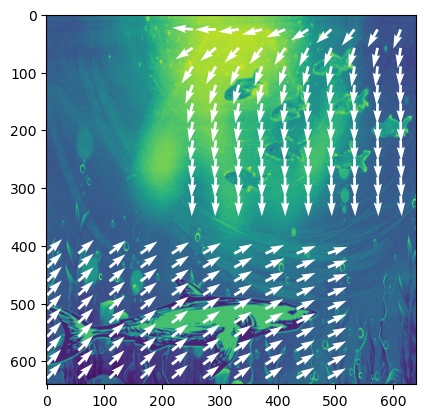

In [554]:
def convert_to_grayscale(path):

    image = np.float32(cv2.imread(path))
    sz = image.shape
    values=np.zeros((image.shape[0],image.shape[1]))
    if (len(sz) == 3):
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                values[i][j] = (image[i][j][0]  + image[i][j][1]  + image[i][j][2])/3
    else:
        values = image;

    values = values/np.max(values)

    return values

path1 = '/Users/danil/Documents/Python projects/Autozoning/sea1.png'
path2 = '/Users/danil/Documents/Python projects/Autozoning/sea2.png'

first=convert_to_grayscale(path1)
second=convert_to_grayscale(path2)

#first -> second
for k in range(len(frame1)):
    for i in range(corners[k][0],corners[k][1],round(abs(corners[k][0]-corners[k][1])/10)+1):
        for j in range(corners[k][2],corners[k][3],round(abs(corners[k][2]-corners[k][3])/10)+1):
            if first[i][j]!=0.0:
                plt.quiver(j+1,i, a[k][len(a[k])-1][0][0]*i + a[k][len(a[k])-1][0][1]*j + c[k][len(c[k])-1][0], - a[k][len(a[k])-1][1][0]*i + a[k][len(a[k])-1][1][1]*j -c[k][len(c[k])-1][1], color=(1,1,1));

# x,y=np.meshgrid(np.linspace(0,first.shape[0],first.shape[0]-int(first.shape[0]*0.1)),np.linspace(0,first.shape[0],first.shape[0]-int(first.shape[0]*0.1)))
# plt.quiver(x,y, 0.01,0.01);

plt.imshow(first)

In [555]:
dJda1_11=[0.0]*len(dJda[0])
dJda1_12=[0.0]*len(dJda[0])
dJda1_21=[0.0]*len(dJda[0])
dJda2_11=[0.0]*len(dJda[0])
dJda2_12=[0.0]*len(dJda[0])
dJda2_21=[0.0]*len(dJda[0])
a1_11=[0.0]*len(a[0])
a1_12=[0.0]*len(a[0])
a1_21=[0.0]*len(a[0])
a2_11=[0.0]*len(a[0])
a2_12=[0.0]*len(a[0])
a2_21=[0.0]*len(a[0])

for i in range(len(dJda[0])):
  dJda1_11[i]=dJda[0][i][0]
  dJda1_12[i]=dJda[0][i][1]
  dJda1_21[i]=dJda[0][i][2]
  dJda2_11[i]=dJda[1][i][0]
  dJda2_12[i]=dJda[1][i][1]
  dJda2_21[i]=dJda[1][i][2]

for i in range(len(a[0])):
  a1_11[i]=a[0][i][0][0]
  a1_12[i]=a[0][i][0][1]
  a1_21[i]=a[0][i][1][0]
  a2_11[i]=a[1][i][0][0]
  a2_12[i]=a[1][i][0][1]
  a2_21[i]=a[1][i][1][0]

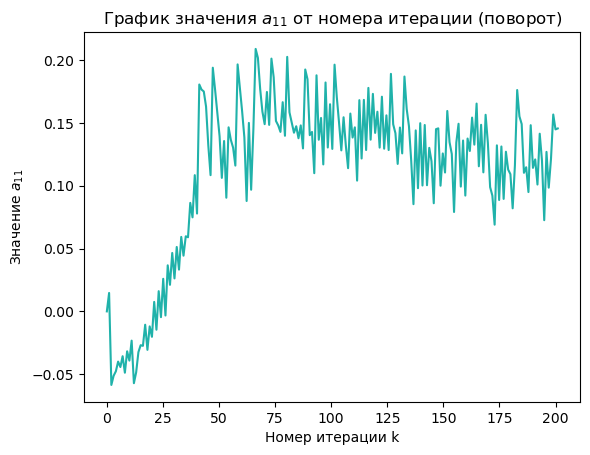

In [556]:
num_iter=np.linspace(0,len(a[0]), len(a[0]))
plt.title("График значения $а_{11}$ от номера итерации (поворот)") # заголовок
plt.xlabel("Номер итерации k") # ось абсцисс
plt.ylabel("Значение $а_{11}$") # ось ординат
plt.plot(num_iter,a1_11, color='lightseagreen')

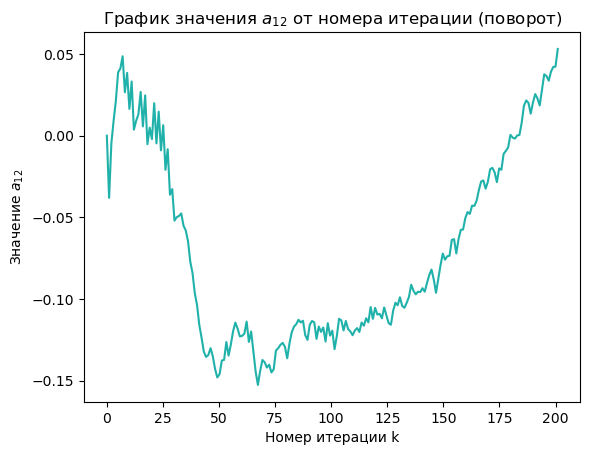

In [557]:
num_iter=np.linspace(0,len(a[0]), len(a[0]))
plt.title("График значения $а_{12}$ от номера итерации (поворот)") # заголовок
plt.xlabel("Номер итерации k") # ось абсцисс
plt.ylabel("Значение $а_{12}$") # ось ординат
plt.plot(num_iter,a1_12, color='lightseagreen')

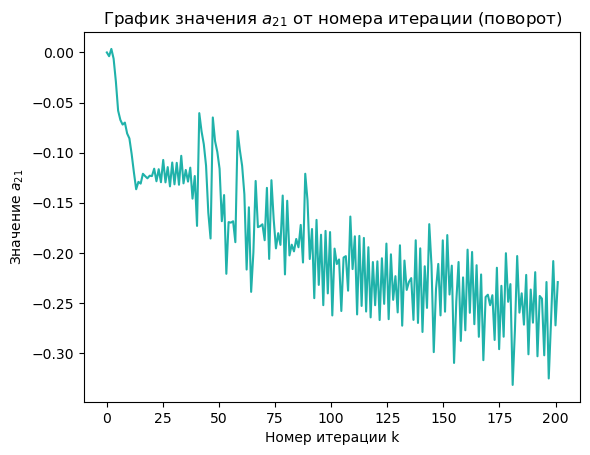

In [558]:
num_iter=np.linspace(0,len(a[0]), len(a[0]))
plt.title("График значения $а_{21}$ от номера итерации (поворот)") # заголовок
plt.xlabel("Номер итерации k") # ось абсцисс
plt.ylabel("Значение $а_{21}$") # ось ординат
plt.plot(num_iter,a1_21, color='lightseagreen')

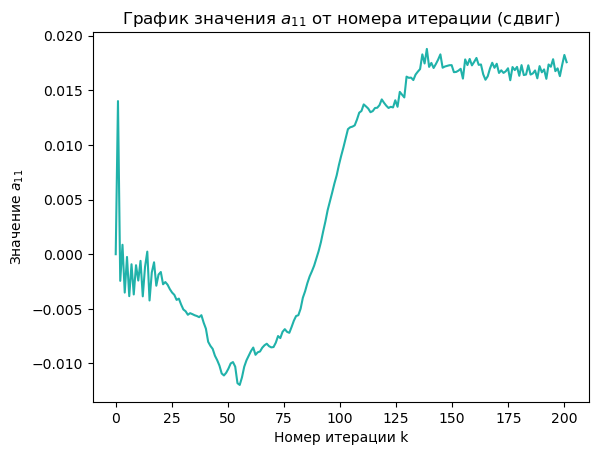

In [559]:
num_iter=np.linspace(0,len(a[0]), len(a[0]))
plt.title("График значения $а_{11}$ от номера итерации (сдвиг)") # заголовок
plt.xlabel("Номер итерации k") # ось абсцисс
plt.ylabel("Значение $а_{11}$") # ось ординат
plt.plot(num_iter,a2_11, color='lightseagreen')

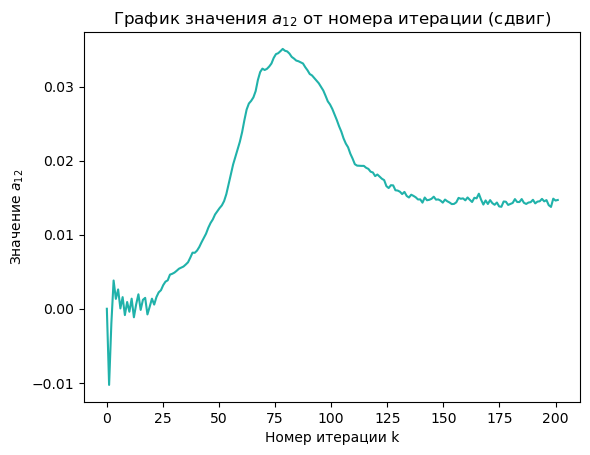

In [560]:
num_iter=np.linspace(0,len(a[0]), len(a[0]))
plt.title("График значения $а_{12}$ от номера итерации (сдвиг)") # заголовок
plt.xlabel("Номер итерации k") # ось абсцисс
plt.ylabel("Значение $а_{12}$") # ось ординат
plt.plot(num_iter,a2_12, color='lightseagreen')

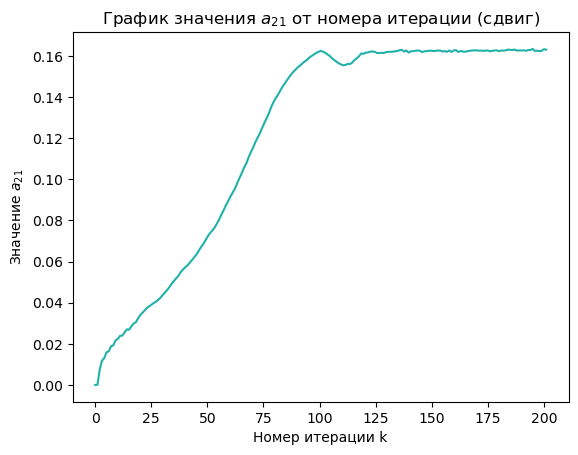

In [561]:
num_iter=np.linspace(0,len(a[0]), len(a[0]))
plt.title("График значения $а_{21}$ от номера итерации (сдвиг)") # заголовок
plt.xlabel("Номер итерации k") # ось абсцисс
plt.ylabel("Значение $а_{21}$") # ось ординат
plt.plot(num_iter,a2_21, color='lightseagreen')

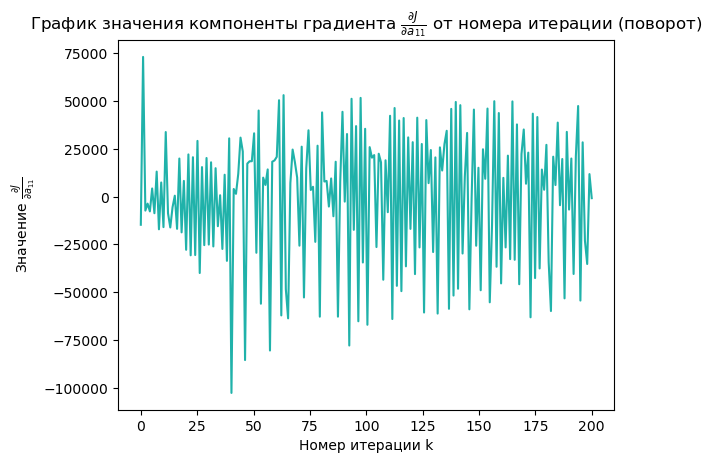

In [562]:
num_iter=np.linspace(0,len(dJda[0]), len(dJda[0]))
plt.title(r'График значения компоненты градиента $\frac{\partial J}{\partial а_{11}}$ от номера итерации (поворот)') # заголовок
plt.xlabel("Номер итерации k") # ось абсцисс
plt.ylabel(r'Значение $\frac{\partial J}{\partial а_{11}}$') # ось ординат
plt.plot(num_iter,dJda1_11, color='lightseagreen')

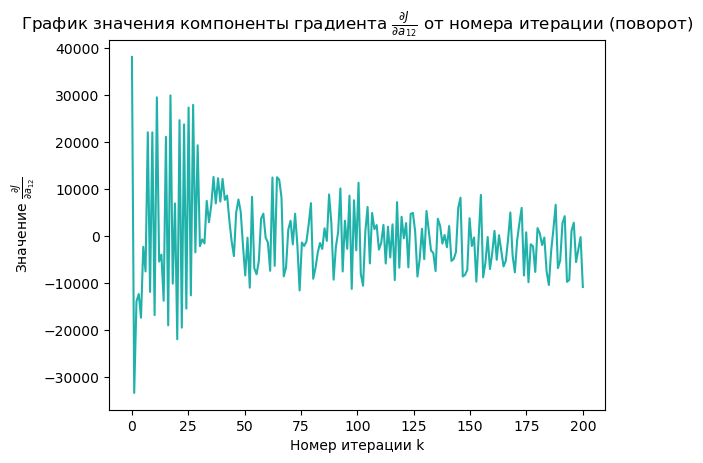

In [563]:
num_iter=np.linspace(0,len(dJda[0]), len(dJda[0]))
plt.title(r'График значения компоненты градиента $\frac{\partial J}{\partial а_{12}}$ от номера итерации (поворот)') # заголовок
plt.xlabel("Номер итерации k") # ось абсцисс
plt.ylabel(r'Значение $\frac{\partial J}{\partial а_{12}}$') # ось ординат
plt.plot(num_iter,dJda1_12, color='lightseagreen')

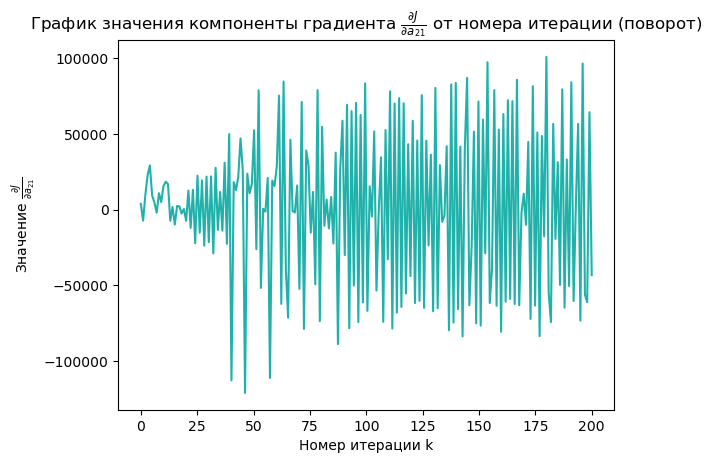

In [564]:
num_iter=np.linspace(0,len(dJda[0]), len(dJda[0]))
plt.title(r'График значения компоненты градиента $\frac{\partial J}{\partial а_{21}}$ от номера итерации (поворот)') # заголовок
plt.xlabel("Номер итерации k") # ось абсцисс
plt.ylabel(r'Значение $\frac{\partial J}{\partial а_{21}}$') # ось ординат
plt.plot(num_iter,dJda1_21, color='lightseagreen')

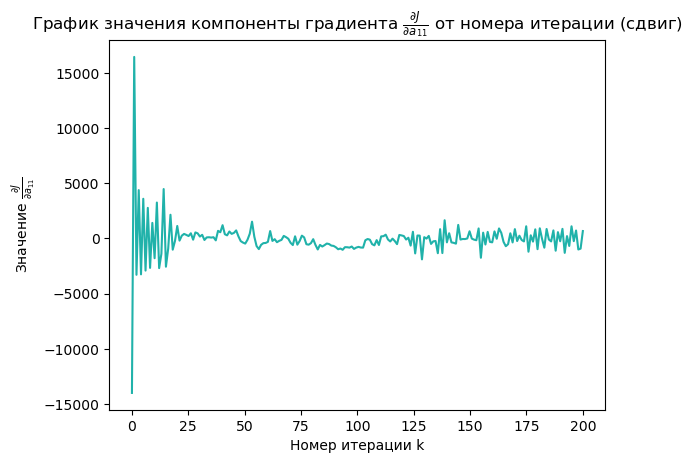

In [565]:
num_iter=np.linspace(0,len(dJda[0]), len(dJda[0]))
plt.title(r'График значения компоненты градиента $\frac{\partial J}{\partial а_{11}}$ от номера итерации (сдвиг)') # заголовок
plt.xlabel("Номер итерации k") # ось абсцисс
plt.ylabel(r'Значение $\frac{\partial J}{\partial а_{11}}$') # ось ординат
plt.plot(num_iter,dJda2_11, color='lightseagreen')

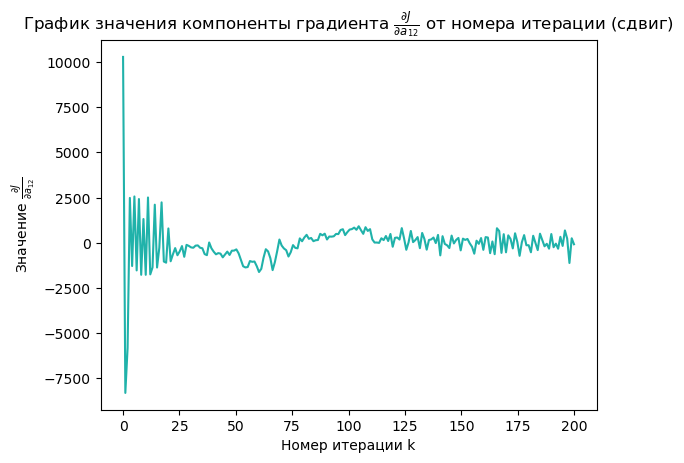

In [566]:
num_iter=np.linspace(0,len(dJda[0]), len(dJda[0]))
plt.title(r'График значения компоненты градиента $\frac{\partial J}{\partial а_{12}}$ от номера итерации (сдвиг)') # заголовок
plt.xlabel("Номер итерации k") # ось абсцисс
plt.ylabel(r'Значение $\frac{\partial J}{\partial а_{12}}$') # ось ординат
plt.plot(num_iter,dJda2_12, color='lightseagreen')

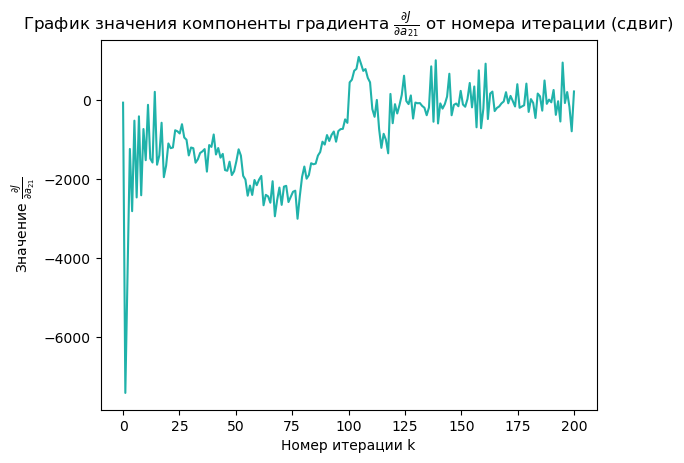

In [567]:
num_iter=np.linspace(0,len(dJda[0]), len(dJda[0]))
plt.title(r'График значения компоненты градиента $\frac{\partial J}{\partial а_{21}}$ от номера итерации (сдвиг)') # заголовок
plt.xlabel("Номер итерации k") # ось абсцисс
plt.ylabel(r'Значение $\frac{\partial J}{\partial а_{21}}$') # ось ординат
plt.plot(num_iter,dJda2_21, color='lightseagreen')

In [568]:
dJdc1_1=[0.0]*len(dJdc[0])
dJdc1_2=[0.0]*len(dJdc[0])
dJdc2_1=[0.0]*len(dJdc[0])
dJdc2_2=[0.0]*len(dJdc[0])
c1_1=[0.0]*len(c[0])
c1_2=[0.0]*len(c[0])
c2_1=[0.0]*len(c[0])
c2_2=[0.0]*len(c[0])


for i in range(len(dJdc[0])):
  dJdc1_1[i]=dJdc[0][i][0]
  dJdc1_2[i]=dJdc[0][i][1]
  dJdc2_1[i]=dJdc[1][i][0]
  dJdc2_2[i]=dJdc[1][i][1]

for i in range(len(c[0])):
  c1_1[i]=c[0][i][0]
  c1_2[i]=c[0][i][1]
  c2_1[i]=c[1][i][0]
  c2_2[i]=c[1][i][1]

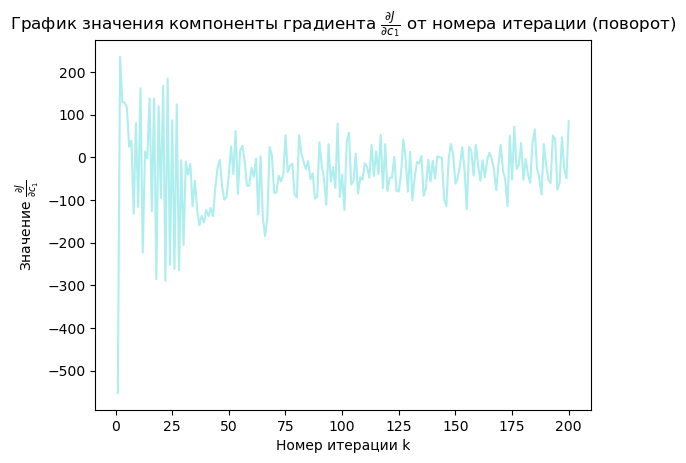

In [569]:
num_iter=np.linspace(1,len(dJdc[0]), len(dJdc[0]))
plt.title(r'График значения компоненты градиента $\frac{\partial J}{\partial c_{1}}$ от номера итерации (поворот)') # заголовок
plt.xlabel("Номер итерации k") # ось абсцисс
plt.ylabel(r'Значение $\frac{\partial J}{\partial c_{1}}$') # ось ординат
plt.plot(num_iter,dJdc1_1,color='paleturquoise')

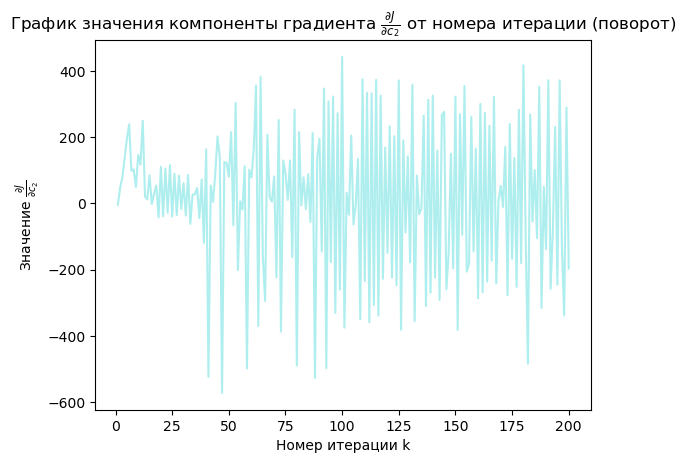

In [570]:
num_iter=np.linspace(1,len(dJdc[0]), len(dJdc[0]))
plt.title(r'График значения компоненты градиента $\frac{\partial J}{\partial c_{2}}$ от номера итерации (поворот)') # заголовок
plt.xlabel("Номер итерации k") # ось абсцисс
plt.ylabel(r'Значение $\frac{\partial J}{\partial c_{2}}$') # ось ординат
plt.plot(num_iter,dJdc1_2,color='paleturquoise')

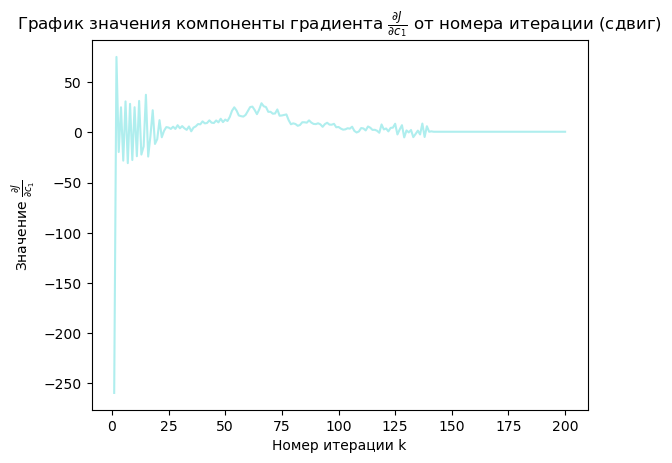

In [571]:
num_iter=np.linspace(1,len(dJdc[0]), len(dJdc[0]))
plt.title(r'График значения компоненты градиента $\frac{\partial J}{\partial c_{1}}$ от номера итерации (сдвиг)') # заголовок
plt.xlabel("Номер итерации k") # ось абсцисс
plt.ylabel(r'Значение $\frac{\partial J}{\partial c_{1}}$') # ось ординат
plt.plot(num_iter,dJdc2_1,color='paleturquoise')

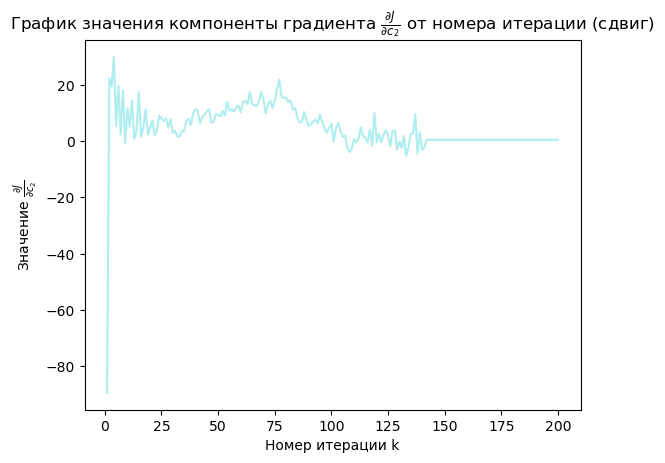

In [572]:
num_iter=np.linspace(1,len(dJdc[0]), len(dJdc[0]))
plt.title(r'График значения компоненты градиента $\frac{\partial J}{\partial c_{2}}$ от номера итерации (сдвиг)') # заголовок
plt.xlabel("Номер итерации k") # ось абсцисс
plt.ylabel(r'Значение $\frac{\partial J}{\partial c_{2}}$') # ось ординат
plt.plot(num_iter,dJdc2_2,color='paleturquoise')

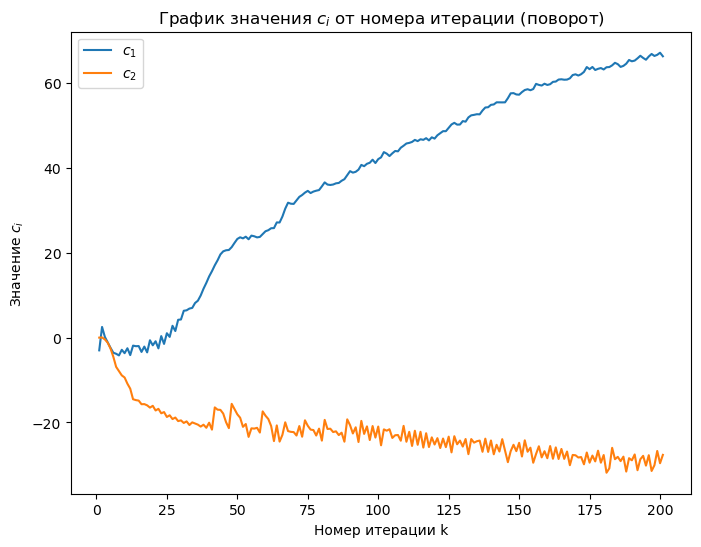

In [573]:
num_iter=np.linspace(1,len(c[0]), len(c[0]))


fig, ax = plt.subplots(figsize=(8, 6))

plt.title(r'График значения $c_{i}$ от номера итерации (поворот)') # заголовок
ax.set_xlabel("Номер итерации k") # ось абсцисс
plt.ylabel("Значение $c_{i}$") # ось ординат
ax.plot(num_iter, c1_1, label="$c_{1}$")
ax.plot(num_iter, c1_2, label="$c_{2}$")
ax.legend()

plt.show()

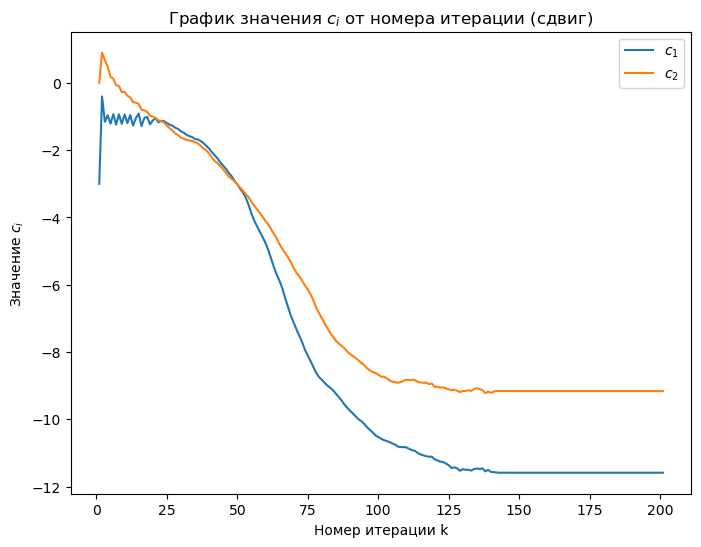

In [574]:
num_iter=np.linspace(1,len(c[0]), len(c[0]))


fig, ax = plt.subplots(figsize=(8, 6))

plt.title(r'График значения $c_{i}$ от номера итерации (сдвиг)') # заголовок
ax.set_xlabel("Номер итерации k") # ось абсцисс
plt.ylabel("Значение $c_{i}$") # ось ординат
ax.plot(num_iter, c2_1, label="$c_{1}$")
ax.plot(num_iter, c2_2, label="$c_{2}$")
ax.legend()

plt.show()

In [575]:
dJdt1=[0.0]*len(dJdt[0])
dJdt2=[0.0]*len(dJdt[0])
t1=[0.0]*len(t[0])
t2=[0.0]*len(t[0])

for i in range(len(dJdt[0])):
  dJdt1[i]=dJdt[0][i][0]
  dJdt2[i]=dJdt[1][i][0]

for i in range(len(t[0])):
  t1[i]=t[0][i][0]
  t2[i]=t[1][i][0]

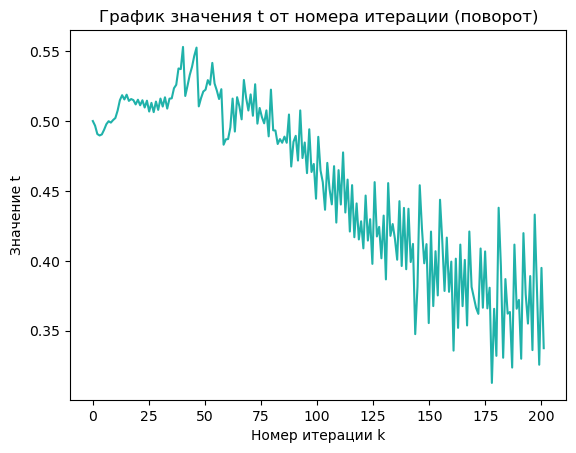

In [576]:
num_iter=np.linspace(0,len(t[0]), len(t[0]))
plt.title("График значения t от номера итерации (поворот)") # заголовок
plt.xlabel("Номер итерации k") # ось абсцисс
plt.ylabel("Значение t") # ось ординат
plt.plot(num_iter,t1, color='lightseagreen')

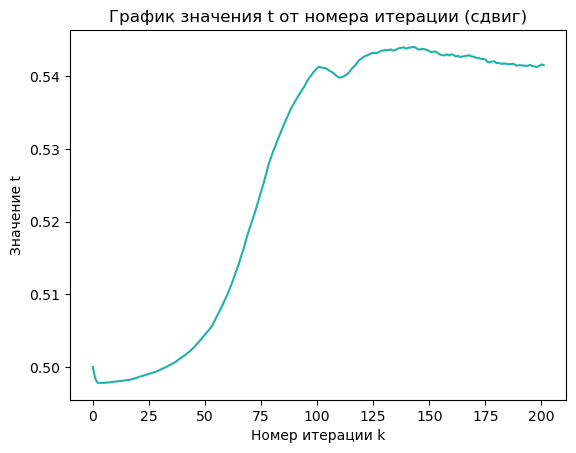

In [577]:
num_iter=np.linspace(0,len(t[0]), len(t[0]))
plt.title("График значения t от номера итерации (сдвиг)") # заголовок
plt.xlabel("Номер итерации k") # ось абсцисс
plt.ylabel("Значение t") # ось ординат
plt.plot(num_iter,t2, color='lightseagreen')

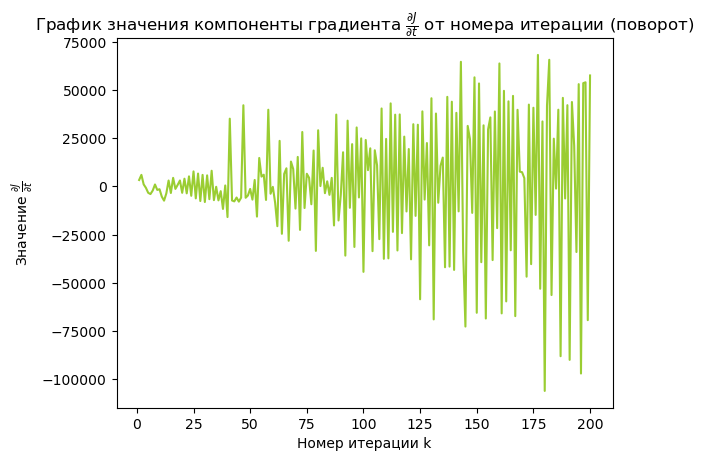

In [578]:
num_iter=np.linspace(1,len(dJdt[0]), len(dJdt[0]))
plt.title(r'График значения компоненты градиента $\frac{\partial J}{\partial t}$ от номера итерации (поворот)') # заголовок
plt.xlabel("Номер итерации k") # ось абсцисс
plt.ylabel(r'Значение $\frac{\partial J}{\partial t}$') # ось ординат
plt.plot(num_iter,dJdt1,color='yellowgreen')

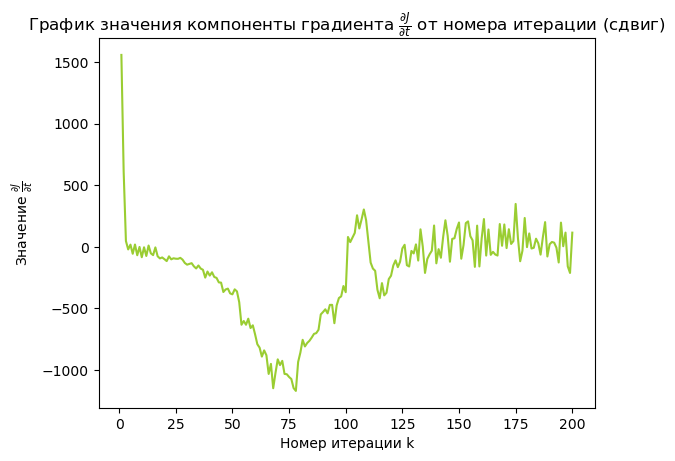

In [579]:
num_iter=np.linspace(1,len(dJdt[0]), len(dJdt[0]))
plt.title(r'График значения компоненты градиента $\frac{\partial J}{\partial t}$ от номера итерации (сдвиг)') # заголовок
plt.xlabel("Номер итерации k") # ось абсцисс
plt.ylabel(r'Значение $\frac{\partial J}{\partial t}$') # ось ординат
plt.plot(num_iter,dJdt2,color='yellowgreen')

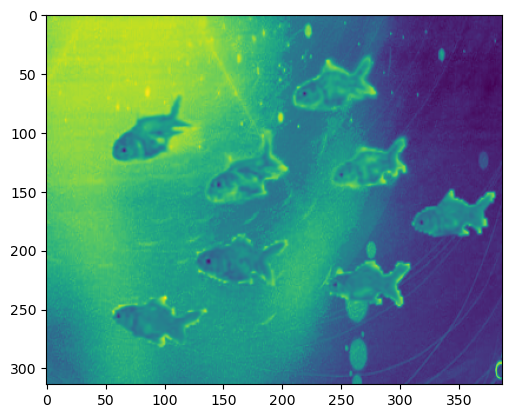

In [580]:
plt.imshow(frame1[1])

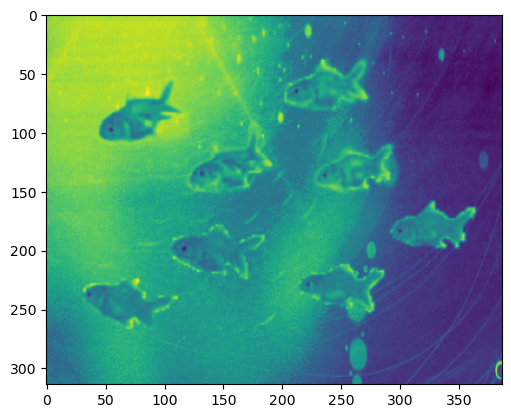

In [552]:
plt.imshow(frame2[1])

In [522]:
 def rho_recalculated(x1,x2,first):
    rho_recalc=np.array([[1.0 for col in range(first.shape[1])] for row in range(first.shape[0])])
    for i in range(second.shape[0]):
        for j in range(second.shape[1]):
          if(x2[i][j]<=first.shape[1]-1 and x2[i][j]>=0 and x1[i][j]<=first.shape[0]-1 and x1[i][j]>=0):
            rho_recalc[x2[i][j]][x1[i][j]]=first[i][j]

    return rho_recalc

In [523]:
plt.imshow(rho_recalculated(x_T[299][0],x_T[299][1],frame1[1]))

IndexError: list index out of range

In [ ]:
plt.imshow(frame1[0])